# Importing/Storing data

In [1]:
# pip install wfdb
# pip install xgboost 
#print('Current directory is: {}'.format(os.getcwd()))

In [68]:
%run "MIT-BIH Normal Sinus Rhythm Database.ipynb"

int32
float64
1806791
-11
Divisble by 20 --> 1806780
Features for that specific segment:
Mean                78.150
STD                  6.552
RMSSD                0.092
Normalized RMSSD     0.001
dtype: float64

features_nsr variable contains 90339 segments
float64
Length of y_list: 90339
shape of y: (18067,), type of y: <class 'numpy.ndarray'>
shape of X_test_nsr: (18067, 4), type of X_test_nsr: <class 'numpy.ndarray'>


In [2]:
import wfdb
import os
import glob
import pandas as pd
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
records = []
properties = []
annot = []
AnnSymb = []
AnnSamp = []
AnnRhythm = []
Rpeak_Samp = []
Rpeak_Symb = []


for f in glob.glob('C:/Users/masud/Desktop/Github_Bachelor_Project/wfdb-python/data/*.dat'): ##### change the path (afib) to your own directory. The rest should 
                                                                                             ##### remin the same
    sig, fields = wfdb.rdsamp(f[:-4], channels=[1])  #### In this function, you have the opportunity to pass 
                                       #### "channels=[0]" or "channels=[1]" to select channel 1 or 2.
    ann = wfdb.rdann(f[:-4], 'atr')
    QRS = wfdb.rdann(f[:-4], 'qrs')
    Symb = pd.Series(ann.symbol)
    Samp = pd.Series(ann.sample)
    QRS_Symb = pd.Series(QRS.symbol)
    QRS_Samp = pd.Series(QRS.sample)
    Rhythm = pd.Series(ann.aux_note)
    records.append(sig)
    properties.append(fields)
    annot.append(ann)
    AnnSymb.append(Symb)
    AnnSamp.append(Samp)
    Rpeak_Symb.append(QRS_Symb)
    Rpeak_Samp.append(QRS_Samp)
    AnnRhythm.append(Rhythm)
    
    

AnnSymb = pd.Series(AnnSymb).values
AnnSamp = pd.Series(AnnSamp).values

In [63]:
#This is only for last record, calculated in above loop
print(AnnRhythm[0])
print("------------------------------------")
print(AnnSamp[0])
print("------------------------------------")
print("All samples of R-peaks below")
print(Rpeak_Samp[0])
print("------------------------------------")
print(Rpeak_Symb[0])
#print(records[0])
#print(type(records[0]))
#print(np.where(Rpeak_Samp[22] <= ))
#df.iloc[22] # acessing ROW 22
#print("------------------------------------")

0        (N
1     (AFIB
2        (N
3     (AFIB
4        (N
5     (AFIB
6        (N
7     (AFIB
8        (N
9     (AFIB
10       (N
11    (AFIB
12       (N
13    (AFIB
14       (N
dtype: object
------------------------------------
0          30
1      102584
2      119604
3      121773
4      122194
5      133348
6      166857
7     1096245
8     1098054
9     1135296
10    1139595
11    1422436
12    1423548
13    1459277
14    1460416
dtype: int32
------------------------------------
All samples of R-peaks below
0             61
1            200
2            358
3            584
4            729
          ...   
44000    8999121
44001    8999327
44002    8999531
44003    8999734
44004    8999941
Length: 44005, dtype: int32
------------------------------------
0        N
1        N
2        N
3        N
4        N
        ..
44000    N
44001    N
44002    N
44003    N
44004    N
Length: 44005, dtype: object


# Pre processing data...

In [5]:
labeled_Rpeaks = []
appended_data = []
for i in range(23): ## 23 records
    for j in range(len(AnnSamp[i])-1): ## AnnSamp or AnnRhythm -- both same dimensions
        df = pd.DataFrame(Rpeak_Samp[i][(Rpeak_Samp[i] > AnnSamp[i][j]) & (Rpeak_Samp[i] < AnnSamp[i][j+1])])
        df['Label'] = AnnRhythm[i][j]
        appended_data.append(df)
        

labeled_Rpeaks = pd.concat(appended_data)
labeled_Rpeaks



,0,Label
0,61,(N
1,200,(N
2,358,(N
3,584,(N
4,729,(N
...,...,...
15373,2849597,(N
15374,2849785,(N
15375,2849975,(N
15376,2850083,(N


### Filter, only get Hearbeats with annotations '(N' OR '(AFIB'

In [6]:
labeled_Rpeaks_N_AFIB = labeled_Rpeaks.loc[(labeled_Rpeaks.Label == '(N') | (labeled_Rpeaks.Label == '(AFIB'), :]
labeled_Rpeaks_N_AFIB[0:1000]

,0,Label
0,61,(N
1,200,(N
2,358,(N
3,584,(N
4,729,(N
...,...,...
995,149897,(AFIB
996,149989,(AFIB
997,150086,(AFIB
998,150169,(AFIB


### Convert 'Label' column to boolean expr

In [7]:
### s.where(s > 1, 10)
#labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype('bool')
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map( 
                   {'(N':False ,'(AFIB':True}) 

<ipython-input-7-36743a647d57>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map(


In [8]:
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)

labeled_Rpeaks_N_AFIB.rename(columns={0: 'Rpeaks'},
          inplace=True, errors='raise')

<ipython-input-8-9cd7ad84a37a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)
D:\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
Rpeaks_N_AFIB = labeled_Rpeaks_N_AFIB["Rpeaks"]
Label_N_AFIB = labeled_Rpeaks_N_AFIB["Label"]
Label_N_AFIB = np.array(Label_N_AFIB, dtype=np.float64)

labeled_Rpeaks_N_AFIB[0:1000]

,Rpeaks,Label
0,61,0
1,200,0
2,358,0
3,584,0
4,729,0
...,...,...
995,149897,1
996,149989,1
997,150086,1
998,150169,1


### Window slider

In [10]:
#print(records[0])
#print(np.shape(records[0]))
#print()
#print()
#records_trans = np.transpose(records[0])
#print(np.shape(records_trans))
#records[0].flatten()
#np.squeeze(records[0], axis=1)
#np.shape(records[0])

In [11]:
###Run with heartbeats ##convert to numpy array 
#from window_slider import Slider
#import numpy
#list = records_trans
#bucket_size = 6600
#overlap_count = 3300
#slider = Slider(bucket_size,overlap_count)
#slider.fit(list)       
#while True:
#    window_data = slider.slide()
#    # do your stuff
#    print(window_data)
#    if slider.reached_end_of_list(): break

### Visualising the ECG signals

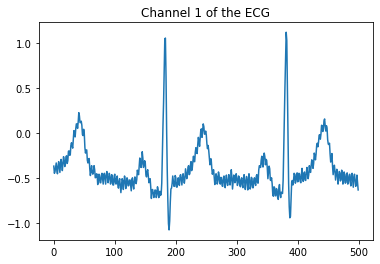

In [12]:
#plt.title("Both Channels (0 and 1)")
#plt.title("Channel 0 of the ECG") #Called ['ECG1']
plt.title('Channel 1 of the ECG') #Called ['ECG2']
plt.plot(sig[:500])

#################### Accessing annotations 
#display(fields) ### Last record annotation
#print(f"Units in which the ECG is measured {fields['units']}")
#display(properties[22])
#print(f"Units in which the ECG is measured {properties[22]['units']}")

# Segmenting & Calculating features METHOD: Rpeaks_N_AFIB

### X

In [13]:
rri2 = np.diff(Rpeaks_N_AFIB) ### Storing the intervals between rpeaks
print(rri2.dtype)
rri2 = np.array(rri2, dtype=np.float64) ### So no overflow issues happens when calc in for loop later
print(rri2.dtype)
print(len(rri2))
amount = -(len(rri2) % 20)
print(amount)
rec_amount = rri2[:amount]
print(len(rec_amount))
segmented_rec = rec_amount.reshape(35428,20)
segmented_rec[0]

int32
float64
708566
-6
708560


array([139., 158., 226., 145., 144., 239., 148., 149., 234., 212., 217.,
       202., 207., 206., 137., 135., 131.,  94., 125., 117.])

In [14]:
features2 = []

    ### Calculating features for every single segmented "block" inside the segmented_record variable
for x in range(len(segmented_rec)):
    #MEAN
    ff1 = np.mean(segmented_rec[x])
    #STD
    ff2 = np.std(segmented_rec[x])
    #RMSSD
    sum_ = 0
    for y in range(len(segmented_rec[x]) - 1): ### loops 19 times
        sum_ += (segmented_rec[x][y] - segmented_rec[x][y+1])**2
    sum_multiplied = 1/(len(segmented_rec) - 1) * sum_
    ff3 = np.sqrt(sum_multiplied)
    #NORMALIZED RMSSD
    ff4 = (ff3 / ff1)

    my_features2 = pd.Series([np.around(ff1,3), np.around(ff2,3), np.around(ff3,3), np.around(ff4,3)], 
                            index=['Mean','STD','RMSSD','Normalized RMSSD'])
    features2.append(my_features2)

In [15]:
n = 0

print(f"Features for that specific segment:\n{features2[n]}") 
print('\n'f"features2 variable contains {len(features2)} segments")

Features for that specific segment:
Mean                168.250
STD                  43.226
RMSSD                 1.115
Normalized RMSSD      0.007
dtype: float64

features2 variable contains 35428 segments


### Y

In [16]:
y_amount = Label_N_AFIB[:- 7] ### So it is divisible by 20
y_shape = y_amount.reshape(35428,20)
y_list = []

### Calc if every 20 segment block is Normal synus rythm or AFIB
for l in range(len(y_shape)):
    #y_segment = y_shape
    sum_segment = np.sum(y_shape[l])
    if sum_segment >= 10:
        sum_segment = 1
    else: sum_segment = 0
    y_list.append(sum_segment)

y_list = np.array(y_list, dtype=np.float64)
print(y_list.dtype)
print(f"Length of y_list: {len(y_list)}")

float64
Length of y_list: 35428


# Segmenting & Calculating features METHOD: RRI

In [17]:
#A sample of 250 elements, gives 1 clear signal (because 250hz frequency)
# single_record_rri = []
# rri = []

# squared_summed_differencies = 0
# i = 0
# for i in range(len(Rpeak_Samp)): ### loops 23 times
#     single_record_rri = np.diff(Rpeak_Samp[i])
#     rri.append(single_record_rri)

In [18]:
# single_record_mean = []
# rri_mean = []
# single_record_std = []
# rri_std = []
# single_record_RMSSD = []
# RMSSD = []
# single_record_nRMSSD = []
# nRMSSD = []

# all_segmented_records = []
# all_features = []


# ### TO acess every single record
# ### record_to_segment = rri[index]
# for index in range(len(rri)): ### Loops 23 times
#     #(below line) gives a value between 0 and 19, which is the amount used to remove from the end of a record, by slicing.
#     amount_to_segment = -(len(rri[index]) % 20)
#     if amount_to_segment != 0:
#         rri_segmented_record = rri[index][:amount_to_segment]
#     else: 
#         rri_segmented_record = rri[index] #if divisible by 20, no need to slice this record
#     #(below line) gives us the number of "blocks" to put every single 20-segment into.
#     length = len(rri_segmented_record) / 20
#     rri_segmented_record = np.split(rri_segmented_record,length)
#     all_segmented_records.append(rri_segmented_record)
    
#     features = []
    
#     ### Calculating features for every single segmented "block" inside the segmented_record variable
#     for i in range(len(rri_segmented_record)):
#         #MEAN
#         f1 = np.mean(rri_segmented_record[i])
#         #STD
#         f2 = np.std(rri_segmented_record[i])
#         #RMSSD
#         sqaured_summed_differencies = 0
#         for k in range(len(rri_segmented_record[i]) - 1): ### loops 19 times
#             sqaured_summed_differencies += (rri_segmented_record[i][k] - rri_segmented_record[i][k+1])**2
#         squared_summed_differencies_multiplied = 1/(len(rri_segmented_record) - 1) * sqaured_summed_differencies
#         f3 = np.sqrt(squared_summed_differencies_multiplied)
#         #NORMALIZED RMSSD
#         f4 = (f3 / f1)
        
#         my_features = pd.Series([np.around(f1,3), np.around(f2,3), np.around(f3,3), np.around(f4,3)], 
#                                 index=['Mean','STD','RMSSD','Normalized RMSSD'])
#         features.append(my_features)
        
#     all_features.append(features)

### Features for a single block (20 heart beats), inside a given record
### Accessing the 23 individual records (index 0 to 22), gives a single record, that is segmented into arrays of 20. Accessing each 20 array segment/block, by indexing, this time second dimension [ ]-->[ ]<--

In [19]:
# n = 3
# m = 156

# print(f"Record nr {n}, and index {m} in that record contains this segment:") 
# print(all_segmented_records[n][m])
# print("Features for that specific segment:") 
# print(all_features[n][m])

# summed = 0
# for z in range(len(all_features)):
#     summed += len(all_features[z])
# print('\n'f"all_features variable contains {summed} segments")

# Estimators -> Classifications algorithms

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [21]:
y = np.asarray(y_list)
print(f"shape of y: {np.shape(y)}, type of y: {type(y)}")
X = np.asarray(features2)
print(f"shape of X: {np.shape(X)}, type of X: {type(X)}")

shape of y: (35428,), type of y: <class 'numpy.ndarray'>
shape of X: (35428, 4), type of X: <class 'numpy.ndarray'>


In [66]:
df5 = pd.DataFrame(features2)
X = df5.values
df5

,Mean,STD,RMSSD,Normalized RMSSD
0,168.25,43.226,1.115,0.007
1,169.10,50.353,1.126,0.007
2,150.75,62.874,1.669,0.011
3,194.20,32.262,1.038,0.005
4,169.85,43.731,1.013,0.006
...,...,...,...,...
35423,189.30,2.326,0.052,0.000
35424,188.80,2.272,0.048,0.000
35425,188.00,2.000,0.056,0.000
35426,187.85,1.621,0.051,0.000


### SVM

In [23]:
model = SVC()

In [24]:
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# clf = GridSearchCV(model, parameters)
# clf.fit(X_train, y_train)

# df_svm_results = pd.DataFrame(clf.cv_results_)
# df_svm_results

In [25]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# scaler = StandardScaler()
# scaler.fit(X)
# scaler.transform(X)

### Decision trees

In [26]:
### How do you select the optimal order?
# clf = tree.DecisionTreeClassifier()
# clf.fit(X_train, y_train)

In [27]:
#clf.score(X_test, y_test) 

### Random forest

In [28]:
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)

In [29]:
# rf_y_predicted = clf.predict(X_test)
# cm = confusion_matrix(y_test, rf_y_predicted)
# %matplotlib inline
# plt.figure(figsize=(6,4))
# sn.heatmap(cm,annot=True)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

# Pipelines

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [31]:
##### Choosen params after runned GridsearchCV 

pipeline_svm = Pipeline([('scalar1', StandardScaler()),
                         ('svm_classifier', SVC(gamma="scale", C=20, kernel='rbf', probability=True))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('dt_classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=12))])

pipeline_nb = Pipeline([('scalar3', StandardScaler()),
                       ('nb_classifier', GaussianNB())]) ### No gridsearch, because no hyperparameters

pipeline_rf = Pipeline([('scalar 4', StandardScaler()),
                         ('rf_classifier', RandomForestClassifier(n_estimators=200))])


In [32]:
# pipelines = [pipeline_svm, pipeline_dt, pipeline_nb, pipeline_rf]
# best_accuracy = 0.0
# best_classifier = 0
# best_pipeline = ""

In [33]:
# pipe_dict = {0: 'Support Vector Machine', 1: 'Decision Tree', 2: 'Naive Bayes', 3: 'Random Forest'}

# for pipe in pipelines:
#     pipe.fit(X_train, y_train)
    
# for i, model in enumerate(pipelines):
#     print(f"{pipe_dict[i]} Test Accuracy: {model.score(X_test, y_test)}")

In [34]:
# for i, model in enumerate(pipelines):
#     if model.score(X_test, y_test) > best_accuracy:
#         best_accuracy = model.score(X_test, y_test)
#         best_pipeline = model
#         best_classifier = i
# print(f"Classifier with best accuracy: {pipe_dict[best_classifier]}")

# Ensemble classifiers

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

### StackingClassifier

In [36]:
estimators = [('svm',pipeline_svm), ('dt',pipeline_dt), ('nb',pipeline_nb), ('rf',pipeline_rf)]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

### xgboost

In [37]:
xgb_model = XGBClassifier()

### AdaBoost

In [38]:
adaBoost_clf = AdaBoostClassifier()

# Cross validation

In [39]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold ### For class inbalances through out the data

In [40]:
scoring = ['precision_macro']

cv_swm_results = cross_validate(pipeline_svm, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False) ### set return_estimator=True to return the fitted estimator

In [41]:
cv_dt_results = cross_validate(pipeline_dt, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)
cv_nb_results = cross_validate(pipeline_nb, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)
cv_rf_results = cross_validate(pipeline_rf, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)
cv_rf_results = cross_validate(pipeline_rf, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)

In [42]:
cv_stacking_results = cross_validate(clf, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)
cv_xgb_results = cross_validate(xgb_model, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)
cv_ab_results = cross_validate(adaBoost_clf, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:45:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Predict values

In [43]:
# y_swm_pred = cross_val_predict(pipeline_svm, X, y)
# y_dt_pred = cross_val_predict(pipeline_dt, X, y)
# y_nb_pred = cross_val_predict(pipeline_nb, X, y)
# y_rf_pred = cross_val_predict(pipeline_rf, X, y)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline_svm.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)
pipeline_nb.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('scalar 4', StandardScaler()),
                ('rf_classifier', RandomForestClassifier(n_estimators=200))])

In [45]:
#r_probs = [0 for _ in range(len(y_test))]
probs_swm = pipeline_svm.predict_proba(X_test)
probs_dt = pipeline_dt.predict_proba(X_test)
probs_nb = pipeline_nb.predict_proba(X_test)
probs_rf = pipeline_rf.predict_proba(X_test)

### Probabilities for the positive outcome is kept
probs_swm = probs_swm[:,1]
probs_dt = probs_dt[:,1]
probs_nb = probs_nb[:,1]
probs_rf = probs_rf[:,1]

In [46]:
auc_svm = metrics.roc_auc_score(y_test, probs_swm)
auc_dt = metrics.roc_auc_score(y_test, probs_dt)
auc_nb = metrics.roc_auc_score(y_test, probs_nb)
auc_rf = metrics.roc_auc_score(y_test, probs_rf)

In [47]:
fpr_swm, tpr_swm, thresholds_swm = metrics.roc_curve(y_test, probs_swm)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, probs_dt)
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(y_test, probs_nb)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, probs_rf)

# Results

In [48]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.datasets import make_classification

### scores

In [62]:
print(f"SWM Scores: {cv_swm_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_swm_results['test_precision_macro'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_dt_results['test_precision_macro'])}")
print()
print(f"Naive bayes Scores: {cv_nb_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_nb_results['test_precision_macro'])}")
print()
print(f"Random forest: {cv_rf_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_rf_results['test_precision_macro'])}")
print()
print(f"Stacking classifier Scores: {cv_stacking_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_stacking_results['test_precision_macro'])}")
print()
print(f"xgboost Scores: {cv_xgb_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_xgb_results['test_precision_macro'])}")
print()
print(f"adaBoost Scores: {cv_ab_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_ab_results['test_precision_macro'])}")

SWM Scores: [0.92118499 0.86178046 0.84719857 0.85588685 0.77298434]
Mean: 0.8518070430052868

Decision tree Scores: [0.90779809 0.89728847 0.87172179 0.87779525 0.7823578 ]
Mean: 0.8673922823519342

Naive bayes Scores: [0.51917108 0.55599557 0.40606327 0.50279532 0.57143782]
Mean: 0.5110926102570704

Random forest: [0.90847345 0.89069007 0.88700552 0.907296   0.79976784]
Mean: 0.8786465777080522

Stacking classifier Scores: [0.91967063 0.89628047 0.88280548 0.91768539 0.79023471]
Mean: 0.8813353363660628

xgboost Scores: [0.91116523 0.89531492 0.89047711 0.90500501 0.80120198]
Mean: 0.8806328505197618

adaBoost Scores: [0.92199619 0.89281512 0.87258715 0.88516904 0.77376375]
Mean: 0.8692662490378071


### Evaluate on MIT-BIH Normal Sinus Rhythm Database

In [75]:
print(f"SVM: {pipeline_svm.score(X_test_nsr, y_test_nsr)}")
print(f"DT: {pipeline_dt.score(X_test_nsr, y_test_nsr)}")
print(f"NB: {pipeline_nb.score(X_test_nsr, y_test_nsr)}")
print(f"RF: {pipeline_rf.score(X_test_nsr, y_test_nsr)}")

SVM: 0.9009796867216472
DT: 0.3611003487020535
NB: 0.9970111252559916
RF: 0.1990922676703382


In [50]:
# print(f"SWM Scores: {np.round(score_svm, 5)}")
# print(f"Mean score: {np.round(np.mean(score_svm), 5)} ({np.round(np.std(score_svm), 5)})")
# print()
# print(f"Decision tree Scores: {np.round(score_dt, 5)}")
# print(f"Mean score: {np.round(np.mean(score_dt), 5)} ({np.round(np.std(score_dt), 5)})")
# print()
# print(f"Naive bayes Scores: {np.round(score_nb, 5)}")
# print(f"Mean score: {np.round(np.mean(score_nb), 5)} ({np.round(np.std(score_nb), 5)})")
# print()
# print(f"Random forest Scores: {np.round(score_rf,5)}")
# print(f"Mean score: {np.round(np.mean(score_rf), 5)} ({np.round(np.std(score_rf), 5)})")
# print()
# print(f"Stacking classifier Scores: {np.round(score_stacking,5)}")
# print(f"Mean score: {np.round(np.mean(score_stacking), 5)} ({np.round(np.std(score_stacking), 5)})")
# print()
# print(f"xgboost Scores: {np.round(score_xgb,5)}")
# print(f"Mean score: {np.round(np.mean(score_xgb), 5)} ({np.round(np.std(score_xgb), 5)})")
# print()
# print(f"adaBoost Scores: {np.round(score_ab,5)}")
# print(f"Mean score: {np.round(np.mean(score_ab), 5)} ({np.round(np.std(score_ab), 5)})")

### Clasification report for SVM

In [51]:
# y_pred_test = pipeline_svm.predict(X_test)
# # print(classification_report(y_pred_test, y_test))

# ### (above) the parameters was inputted in wrong positions.
# target_names = ['class 0', 'class 1']
# print(classification_report(y_test, y_pred_test, target_names=target_names))

### Confusion Matrix

In [52]:
y_pred_svm = pipeline_svm.predict(X_test)
y_pred_dt = pipeline_dt.predict(X_test)
y_pred_nb = pipeline_nb.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_rf = confusion_matrix(y_test, y_pred_rf)
target_names = ['Normal', 'AFIB']

In [53]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

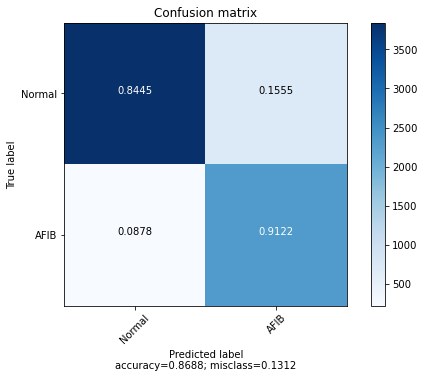

In [54]:
plot_confusion_matrix(cm=cm_svm, target_names=target_names)

### ROC curve

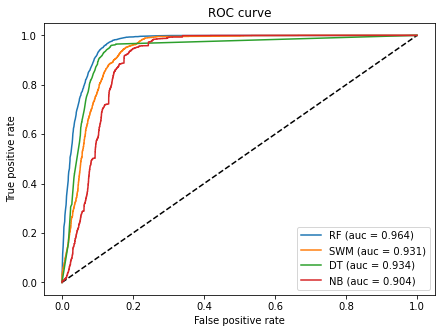

In [55]:
plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
plt.plot(fpr_nb, tpr_nb, label='NB (auc = %0.3f)' % auc_nb)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# GridsearchCV

In [56]:
# from sklearn.model_selection import GridSearchCV
# pipeline_nb.get_params().keys()

In [57]:
# from time import time
# t0 = time()
# parameters = {'svm_classifier__C':[1, 10, 20], 'svm_classifier__kernel':['linear', 'rbf']}
# #parameters = {'rf_classifier__n_estimators': [200, 700], 'rf_classifier__max_features': ['auto', 'sqrt', 'log2'], 'rf_classifier__criterion':['gini','entropy']}
# clf = GridSearchCV(pipeline_swm, parameters, cv=5)
# clf.fit(X_train, y_train)
# print("done in %0.3fs" % (time() - t0))

In [58]:
#df_search_results = pd.DataFrame(clf.cv_results_)
#df_search_results

In [59]:
#df_search_results[['param_rf_classifier__criterion', 'param_rf_classifier__max_depth', 'mean_test_score']]
#clf.best_params_